In [2]:
import os
import sys
from pathlib import Path

import pandas as pd

os.chdir("../")
sys.path.append("./")

## Pasos para preparar datos de train/vak con Hard Negative Mining

1. Ejecutar inferencia sobre imágenes de train y validación originales
2. Identificar Hard Negatives y agregarlos a ground_truth con label=0 (background)
3. Ejecutar el patcher con conjunto de anotaciones aumentadas



### Paso 1: Ejecutar inferencia sobre imágenes de train y test.

Sobre train:

```bash
dvc repro -s infer-train-herdnet-v2
#Running stage 'infer-train-herdnet-v2':
# > python animaloc_improved/tools/infer_v2.py data/train/ \
#   data/models/herdnet_v2/best_model.pth -dest data/inference/herdnet_v2/train
```
![image.png](infer-train-herdnet-v2-A.png)
![image.png](infer-train-herdnet-v2-B.png)

Sobre validación:

```bash
dvc repro -s infer-valid-herdnet-v2
# Running stage 'infer-valid-herdnet-v2':
# > python animaloc_improved/tools/infer_v2.py data/val/
# data/models/herdnet_v2/best_model.pth -dest data/inference/herdnet_v2/val
```

![image.png](infer-valid-herdnet-v2.png)
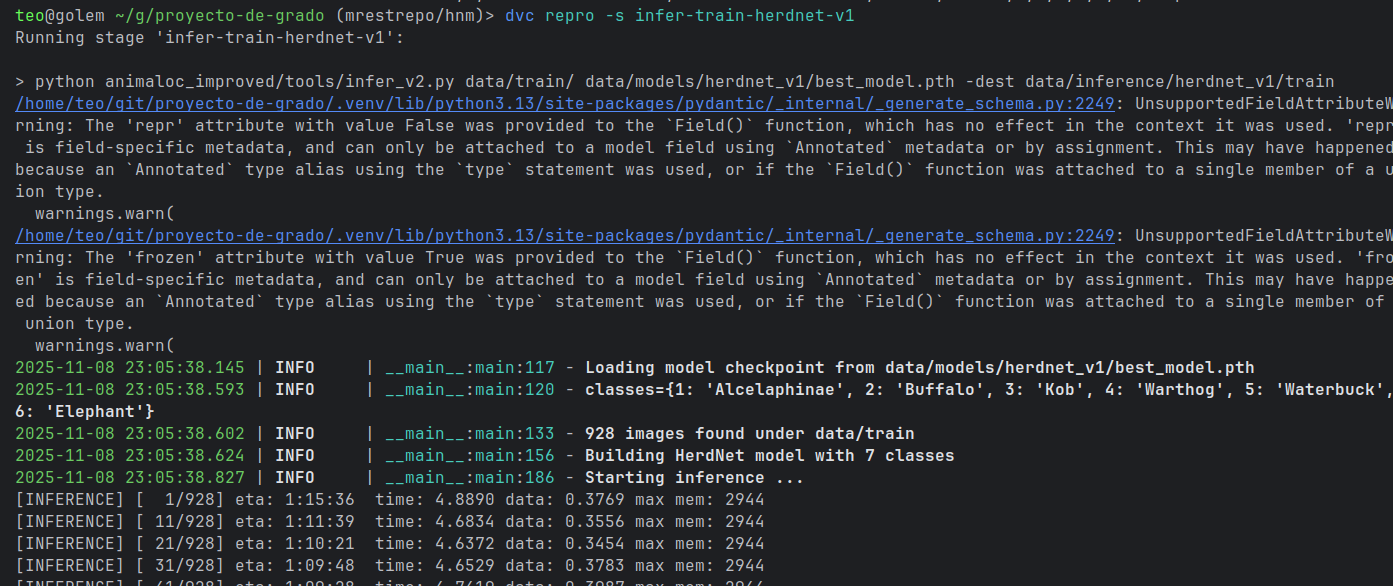
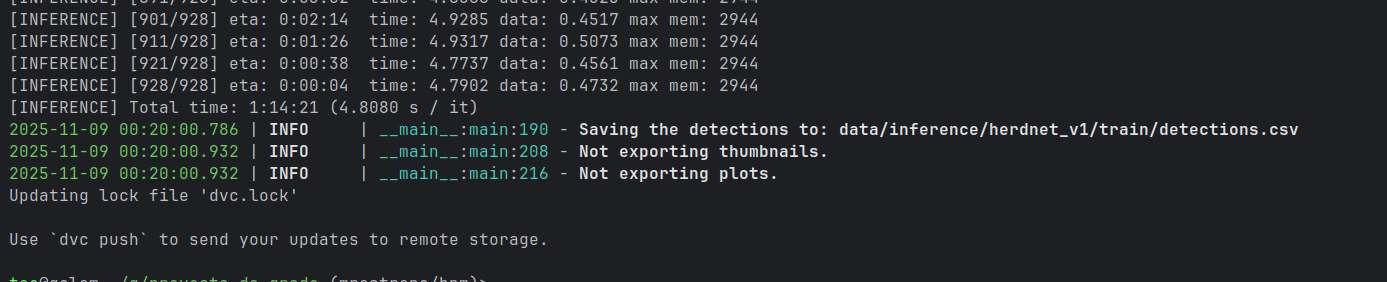
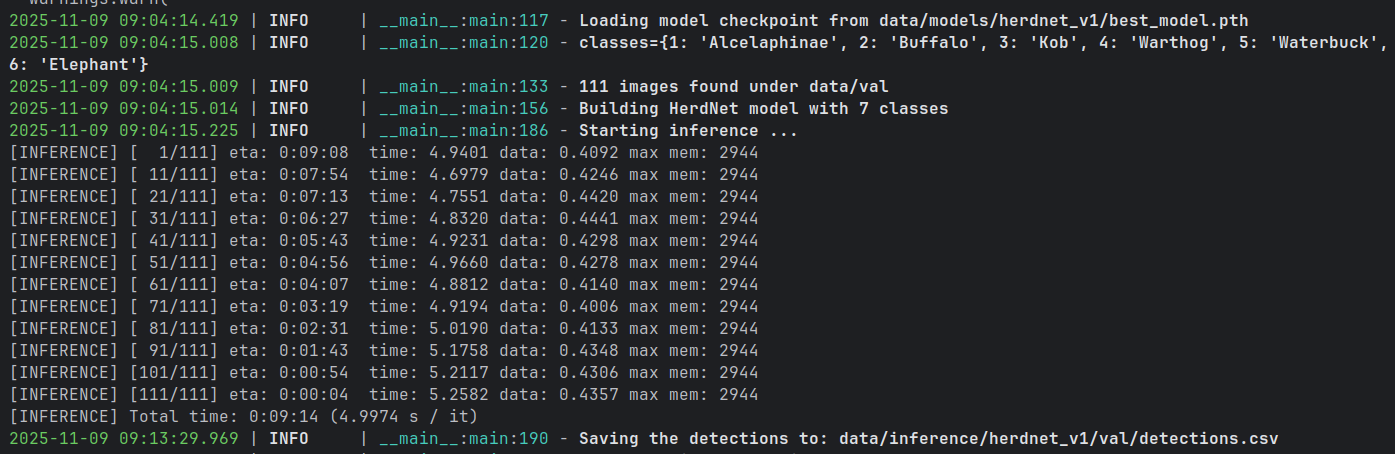
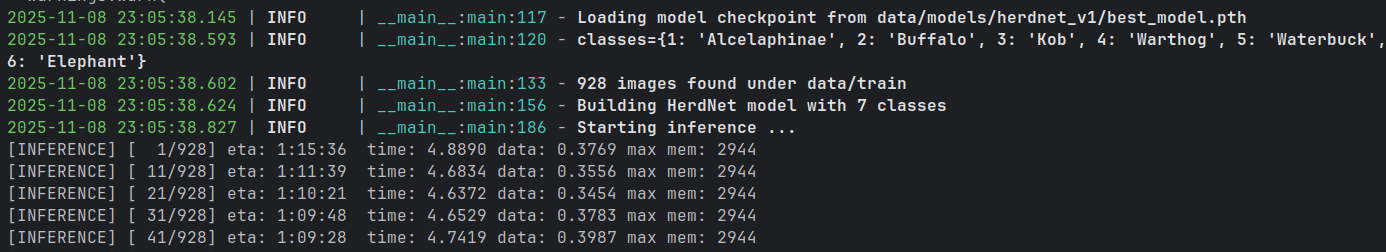
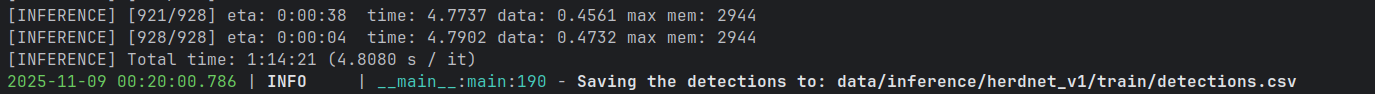

In [3]:
detections_fp = Path("data/inference/herdnet_v2/train/detections.csv")
ground_truth_fp = Path("data/groundtruth/csv/train_big_size_A_B_E_K_WH_WB-fixed-header.csv")

In [4]:
pt_dets = pd.read_csv(detections_fp)[["images", "x", "y", "labels"]]
pt_dets["labels"] = pt_dets["labels"].astype(int)
gt_boxes = pd.read_csv(ground_truth_fp)

In [5]:
pt_dets[["images", "x", "y"]]

,images,x,y
0,S_08_05_16_DSC00674.JPG,1112.0,242.0
1,S_08_05_16_DSC00674.JPG,1156.0,272.0
2,S_08_05_16_DSC00674.JPG,1154.0,274.0
3,S_08_05_16_DSC00674.JPG,362.0,284.0
4,S_08_05_16_DSC00674.JPG,374.0,284.0
...,...,...,...
15379,S_09_05_16_DSC00632.JPG,64.0,3507.0
15380,S_09_05_16_DSC00632.JPG,54.0,3529.0
15381,S_09_05_16_DSC00632.JPG,1764.0,3809.0
15382,L_11_05_16_DSC01207.JPG,4987.0,826.0


In [6]:
gt_boxes

,images,x_min,y_min,x_max,y_max,labels
0,L_07_05_16_DSC00126.JPG,2488,357,2520,427,3
1,L_07_05_16_DSC00126.JPG,1707,446,1746,471,3
2,L_07_05_16_DSC00127.JPG,2612,2314,2641,2361,3
3,L_07_05_16_DSC00127.JPG,1793,2450,1843,2475,3
4,L_07_05_16_DSC00150.JPG,1492,1381,1586,1441,2
...,...,...,...,...,...,...
6957,2f75ff230b98fc9c58d5aa099e0da4b4ca5350eb.JPG,2975,3211,3003,3246,6
6958,2f75ff230b98fc9c58d5aa099e0da4b4ca5350eb.JPG,2986,3439,3019,3490,6
6959,2f75ff230b98fc9c58d5aa099e0da4b4ca5350eb.JPG,1811,993,1842,1033,6
6960,2f75ff230b98fc9c58d5aa099e0da4b4ca5350eb.JPG,1425,993,1468,1079,6


In [7]:
box_counts = gt_boxes["images"].value_counts().reset_index()
box_counts[box_counts.images.str.startswith("0")]

,images,count
38,06932f783fc99926b9e25d5136a03679655af3b8.JPG,32
70,006b4661847b82acfb2b6a3e3677f4ae63f1dd5c.JPG,25
90,01de5b7225fc89e56d57ae1e14cd945cb67f5a0e.JPG,22
98,0ea2fd7b31f21c04b88a53bf07dd65dcd74179be.JPG,20
100,03c04daf5ae49a9434d9ca5928d2aa456168b0cd.JPG,20
...,...,...
770,0fc58dfe6bdd50a54a55c4505ea08128a16eef3e.JPG,1
777,0c64ebb74f22ff1dc956236bfd3b996e19208ba5.JPG,1
778,0cc6202f24123c88f94c1450309fde1f5ac1ce62.JPG,1
779,0d9068d3ddff54d05b7825cbc245e262f3fd2bf2.JPG,1


In [8]:
gt_by_image = gt_boxes.groupby("images")

In [9]:
pt_dets[pt_dets.images == "06932f783fc99926b9e25d5136a03679655af3b8.JPG"]

,images,x,y,labels
9797,06932f783fc99926b9e25d5136a03679655af3b8.JPG,3185.0,272.0,6
9798,06932f783fc99926b9e25d5136a03679655af3b8.JPG,3189.0,272.0,6
9799,06932f783fc99926b9e25d5136a03679655af3b8.JPG,1702.0,460.0,6
9800,06932f783fc99926b9e25d5136a03679655af3b8.JPG,3947.0,552.0,6
9801,06932f783fc99926b9e25d5136a03679655af3b8.JPG,2360.0,616.0,6
9802,06932f783fc99926b9e25d5136a03679655af3b8.JPG,2348.0,648.0,6
9803,06932f783fc99926b9e25d5136a03679655af3b8.JPG,3749.0,648.0,6
9804,06932f783fc99926b9e25d5136a03679655af3b8.JPG,2404.0,690.0,6
9805,06932f783fc99926b9e25d5136a03679655af3b8.JPG,2414.0,712.0,6
9806,06932f783fc99926b9e25d5136a03679655af3b8.JPG,2415.0,716.0,6


In [10]:
row = pt_dets.iloc[9797]
row

images    06932f783fc99926b9e25d5136a03679655af3b8.JPG
x                                               3185.0
y                                                272.0
labels                                               6
Name: 9797, dtype: object

In [11]:
boxes_in_image = gt_by_image.get_group(row["images"])
boxes_in_image

,images,x_min,y_min,x_max,y_max,labels
5219,06932f783fc99926b9e25d5136a03679655af3b8.JPG,2817,1673,2899,1706,6
5220,06932f783fc99926b9e25d5136a03679655af3b8.JPG,2704,1599,2786,1658,6
5221,06932f783fc99926b9e25d5136a03679655af3b8.JPG,2844,1504,2875,1551,6
5222,06932f783fc99926b9e25d5136a03679655af3b8.JPG,2771,1434,2846,1484,6
5223,06932f783fc99926b9e25d5136a03679655af3b8.JPG,2902,1011,2956,1105,6
5224,06932f783fc99926b9e25d5136a03679655af3b8.JPG,3251,843,3297,866,6
5225,06932f783fc99926b9e25d5136a03679655af3b8.JPG,3652,733,3694,784,6
5226,06932f783fc99926b9e25d5136a03679655af3b8.JPG,3740,793,3780,849,6
5227,06932f783fc99926b9e25d5136a03679655af3b8.JPG,3708,626,3795,671,6
5228,06932f783fc99926b9e25d5136a03679655af3b8.JPG,3857,782,3918,835,6


In [12]:
det_in_boxes = (  # Series of bool
    (row["x"] >= boxes_in_image["x_min"])
    & (row["x"] <= boxes_in_image["x_max"])
    & (row["y"] >= boxes_in_image["y_min"])
    & (row["y"] <= boxes_in_image["y_max"])
)
det_in_boxes.sum()

np.int64(1)

In [13]:
def is_false_positive_point(point_det: pd.Series) -> pd.Series:
    boxes_in_image = gt_by_image.get_group(point_det["images"])

    det_in_boxes = (
        (point_det["x"] >= boxes_in_image["x_min"])
        & (point_det["x"] <= boxes_in_image["x_max"])
        & (point_det["y"] >= boxes_in_image["y_min"])
        & (point_det["y"] <= boxes_in_image["y_max"])
    )

    return det_in_boxes.sum() == 0


pt_dets["is_false_positive"] = pt_dets.apply(is_false_positive_point, axis=1)
pt_dets["is_false_positive"].value_counts()

is_false_positive
False    9797
True     5587
Name: count, dtype: int64

In [14]:
pt_dets

,images,x,y,labels,is_false_positive
0,S_08_05_16_DSC00674.JPG,1112.0,242.0,1,False
1,S_08_05_16_DSC00674.JPG,1156.0,272.0,3,False
2,S_08_05_16_DSC00674.JPG,1154.0,274.0,3,False
3,S_08_05_16_DSC00674.JPG,362.0,284.0,1,False
4,S_08_05_16_DSC00674.JPG,374.0,284.0,1,False
...,...,...,...,...,...
15379,S_09_05_16_DSC00632.JPG,64.0,3507.0,6,True
15380,S_09_05_16_DSC00632.JPG,54.0,3529.0,6,True
15381,S_09_05_16_DSC00632.JPG,1764.0,3809.0,3,True
15382,L_11_05_16_DSC01207.JPG,4987.0,826.0,4,False


## 2. Detectar falsos positivos y agregarlos a anotaciones de ground truth  con label 0

In [15]:
!dvc repro -s -f mine-hard-negs-herdnet-v2

Running stage 'mine-hard-negs-herdnet-v2':
> python animaloc_improved/tools/mine_hard_negs.py from-pt-dets --gt_boxes data/groundtruth/csv/train_big_size_A_B_E_K_WH_WB-fixed-header.csv --pt_dets  data/inference/herdnet_v2/train/detections.csv --out      data/gt-preprocessed/csv/train_gt_boxes_and_hard_negs.csv && python animaloc_improved/tools/mine_hard_negs.py from-pt-dets --gt_boxes data/groundtruth/csv/val_big_size_A_B_E_K_WH_WB-fixed-header.csv --pt_dets  data/inference/herdnet_v2/val/detections.csv --out      data/gt-preprocessed/csv/val_gt_boxes_and_hard_negs.csv
2025-11-09 17:59:23.991 | INFO     | __main__:mine_hard_negs_points:25 - Loaded 6,962 ground truth boxes from: data/groundtruth/csv/train_big_size_A_B_E_K_WH_WB-fixed-header.csv
2025-11-09 17:59:24.005 | INFO     | __main__:mine_hard_negs_points:27 - Loaded 15,384 point detections from: data/inference/herdnet_v2/train/detections.csv
2025-11-09 17:59:30.636 | INFO     | __main__:mine_hard_negs_points:49 - False positives 

## 3. Ejecutar patcher con anotaciones aumentadas

```bash
dvc repro -s patches-512-ol-160-mv01-with-hard-negs-train
dvc repro -s patches-512-ol-160-mv01-with-hard-negs-val

# comandos ejecutados
python oficial_herdnet/tools/patcher.py data/train 512 512 160 \
    data/patches-512-ol-160-m01-w-hard-negs/train \
    -csv data/gt-preprocessed/csv/train_gt_boxes_and_hard_negs.csv \
 && \
   cp data/patches-512-ol-160-m01-w-hard-negs/train/gt.csv \
      data/patches-512-ol-160-m01-w-hard-negs/train_points_gt.csv


python oficial_herdnet/tools/patcher.py data/val 512 512 160 \
    data/patches-512-ol-160-m01-w-hard-negs/val \
    -csv data/gt-preprocessed/csv/val_gt_boxes_and_hard_negs.csv \
 && \
   cp data/patches-512-ol-160-m01-w-hard-negs/val/gt.csv \
      data/patches-512-ol-160-m01-w-hard-negs/val_points_gt.csv
```

In [16]:
# Número de parches en cada dataset
!ls -1 data/patches-512-ol-160-m01-w-hard-negs/train | wc -l
!ls -1 data/patches-512-ol-160-m01-w-hard-negs/val | wc -l

17153
2371


In [17]:
# Comparando esto con números de archivos en cada dataset antes de HNM
!ls -1 data/patches-512-ol-160-m01/train | wc -l
!ls -1 data/patches-512-ol-160-m01/val | wc -l

8582
1167


In [18]:
# Anotaciones con Hard Negs
from data_exploration.utils import summarize_points_gt

# train
summarize_points_gt(Path("data/patches-512-ol-160-m01-w-hard-negs/train_points_gt.csv"))

archivo: data/patches-512-ol-160-m01-w-hard-negs/train_points_gt.csv

25781 filas - 14 columnas: [images, labels, base_images, scores, dscores, count_1, count_2, count_3, count_4, count_5, count_6, species, x, y]

## Número de valores únicos por columna:
|             |     0 |
|:------------|------:|
| images      | 17152 |
| labels      |     7 |
| base_images |   928 |
| scores      |  5263 |
| dscores     |  5586 |
| count_1     |    40 |
| count_2     |    35 |
| count_3     |    38 |
| count_4     |    13 |
| count_5     |    16 |
| count_6     |    59 |
| species     |     6 |
| x           |   511 |
| y           |   511 |

## Conteos de nulos por columna:
|    | index       |     0 |
|---:|:------------|------:|
|  0 | images      |     0 |
|  1 | labels      |     0 |
|  2 | base_images |     0 |
|  3 | scores      | 14026 |
|  4 | dscores     | 14026 |
|  5 | count_1     | 14026 |
|  6 | count_2     | 14026 |
|  7 | count_3     | 14026 |
|  8 | count_4     | 14026 |
|  9 | c

In [19]:
# val
summarize_points_gt(Path("data/patches-512-ol-160-m01-w-hard-negs/val_points_gt.csv"))

archivo: data/patches-512-ol-160-m01-w-hard-negs/val_points_gt.csv

3815 filas - 14 columnas: [images, labels, base_images, scores, dscores, count_1, count_2, count_3, count_4, count_5, count_6, species, x, y]

## Número de valores únicos por columna:
|             |    0 |
|:------------|-----:|
| images      | 2370 |
| labels      |    7 |
| base_images |  111 |
| scores      |  823 |
| dscores     |  884 |
| count_1     |   21 |
| count_2     |   13 |
| count_3     |   11 |
| count_4     |    9 |
| count_5     |    5 |
| count_6     |   25 |
| species     |    6 |
| x           |  509 |
| y           |  504 |

## Conteos de nulos por columna:
|    | index       |    0 |
|---:|:------------|-----:|
|  0 | images      |    0 |
|  1 | labels      |    0 |
|  2 | base_images |    0 |
|  3 | scores      | 1918 |
|  4 | dscores     | 1918 |
|  5 | count_1     | 1918 |
|  6 | count_2     | 1918 |
|  7 | count_3     | 1918 |
|  8 | count_4     | 1918 |
|  9 | count_5     | 1918 |
| 10 | cou